In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Scaling Only Demo

Here we have four sensors, their calibration remains constant (although the model doesn't know that).

In [2]:
X = np.array([[3.0,0,1],
             [4.0,0,1],
             [5.0,0,1],
             [6.0,1,2],
             [7.0,1,2],
             [8.0,1,2],
             [9.0,1,2],
             [1.0,2,3],
             [2.0,2,3],
             [3.0,2,3],
             [10.5,2,3], 
             [14.0,3,0]])

Y = np.array([[10,20],[15,30],[16,32],[30,20],[33,22],[21,14],[30,20],[20,20],[20,21],[22,23],[15,14],[20,15]])
refsensor = np.array([1,0,0,0])
Z = np.linspace(0,15,5)[:,None]

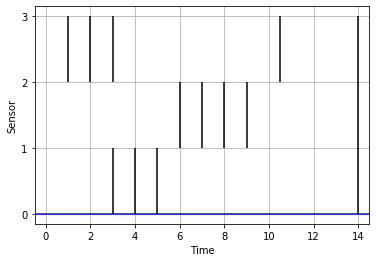

In [3]:
for x in X:
    plt.vlines(x[0],x[1],x[2])
plt.yticks(np.arange(0,3+1),np.arange(0,3+1))
plt.ylabel('Sensor')
plt.xlabel('Time')
plt.hlines(0,-1,15,'b')
plt.xlim([-0.5,14.5])
plt.grid()

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd

In [5]:
def transform_fn(samps,Y):
    return Y*samps[:,:,0:1]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.5)
cs.run(its=500)

W0704 23:39:47.880243 139745090729728 deprecation.py:323] From /home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


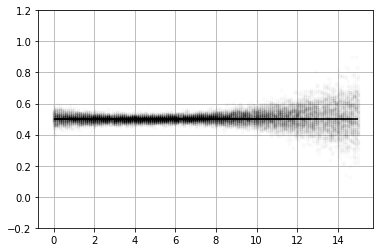

In [6]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,0].numpy().T,'k.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-.2,1.2])
    if si==1: plt.hlines(0.5,0,15)
    if si==2: plt.hlines(0.75,0,15)
    if si==3: plt.hlines(0.75,0,15)
    break

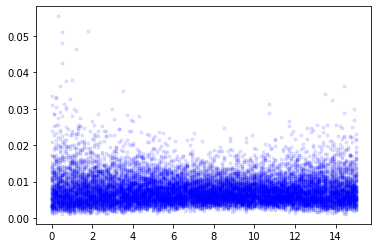

In [12]:
plt.plot(x,np.exp(samps[:,:,1].numpy().T-5),'b.',alpha=0.1);

In [21]:
testX

array([[ 0. ,  1. ,  0. ],
       [ 0.1,  1. ,  0. ],
       [ 0.2,  1. ,  0. ],
       [ 0.3,  1. ,  0. ],
       [ 0.4,  1. ,  0. ],
       [ 0.5,  1. ,  0. ],
       [ 0.6,  1. ,  0. ],
       [ 0.7,  1. ,  0. ],
       [ 0.8,  1. ,  0. ],
       [ 0.9,  1. ,  0. ],
       [ 1. ,  1. ,  0. ],
       [ 1.1,  1. ,  0. ],
       [ 1.2,  1. ,  0. ],
       [ 1.3,  1. ,  0. ],
       [ 1.4,  1. ,  0. ],
       [ 1.5,  1. ,  0. ],
       [ 1.6,  1. ,  0. ],
       [ 1.7,  1. ,  0. ],
       [ 1.8,  1. ,  0. ],
       [ 1.9,  1. ,  0. ],
       [ 2. ,  1. ,  0. ],
       [ 2.1,  1. ,  0. ],
       [ 2.2,  1. ,  0. ],
       [ 2.3,  1. ,  0. ],
       [ 2.4,  1. ,  0. ],
       [ 2.5,  1. ,  0. ],
       [ 2.6,  1. ,  0. ],
       [ 2.7,  1. ,  0. ],
       [ 2.8,  1. ,  0. ],
       [ 2.9,  1. ,  0. ],
       [ 3. ,  1. ,  0. ],
       [ 3.1,  1. ,  0. ],
       [ 3.2,  1. ,  0. ],
       [ 3.3,  1. ,  0. ],
       [ 3.4,  1. ,  0. ],
       [ 3.5,  1. ,  0. ],
       [ 3.6,  1. ,  0. ],
 

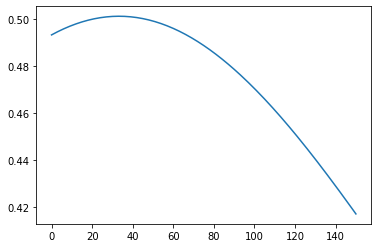

In [22]:
plt.plot(qf_mu[:151,0])

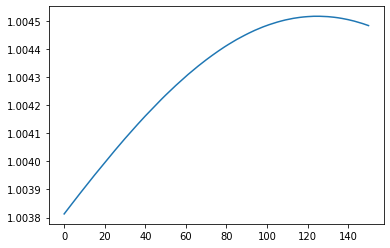

In [23]:
plt.plot(np.exp(qf_mu[151:,0]))

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [31]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [32]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.05)
cs.run(its=1000)

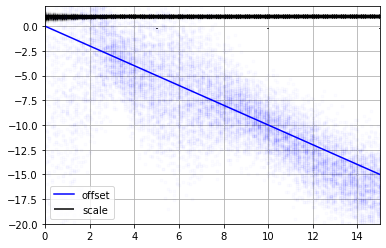

In [40]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.hlines(1,0,15,'k',label='scale')
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.legend(loc='lower left')